# 【問題1】公式Exampleを分担して実行

## TensorFLowの公式Exampleを分担して実行してください。

以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

**research**

定番のモデルから最新のモデルまで多様なコードが公開されています。

[models/research at master · tensorflow/models](https://github.com/tensorflow/models/tree/master/research)

**tutorials**

TensorFLowのチュートリアルとして用意された簡単なモデルが含まれています。

[models/tutorials at master · tensorflow/models](https://github.com/tensorflow/models/tree/master/tutorials)



## インポート

In [1]:
from tqdm import tqdm_notebook as tqdm
import pyprind
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
%matplotlib inline
from tensorflow import keras
import os

Using TensorFlow backend.


## **Save and restore models**

### 重みの保存

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

In [3]:
# 短いシーケンシャルモデルを返す関数
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(784,)),
        keras.layers.Dropout(rate=0.2, seed=0),
        keras.layers.Dense(10, activation=tf.keras.activations.softmax)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model


# 基本的なモデルのインスタンスを作る
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [4]:
# まずは重み等を保存するファイルを作成する。
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# チェックポイントコールバックを作る
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
#モデルを作成
model = create_model()
# 学習
model.fit(train_images, train_labels,  epochs = 10,
          validation_data = (test_images,test_labels),
          callbacks = [cp_callback])  # 訓練にコールバックを渡す

# オプティマイザの状態保存についての警告が表示されるかもしれません。
# これらの警告は（このノートブックで発生する同様な警告を含めて）
# 古い用法を非推奨にするためのもので、無視して構いません。


Train on 1000 samples, validate on 1000 samples
Epoch 1/10
 544/1000 [===============>..............] - ETA: 0s - loss: 1.5004 - acc: 0.5312
Epoch 00001: saving model to training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
1000/1000 [==============================] - 0s 378us/sample - loss: 1.1330 - acc: 0.6620 - val_loss: 0.7281 - val_acc: 0.7800
Epoch 2/10
 576/1000 [================>.............] - ETA: 0s - loss: 0.4971 - acc: 0.8559
Epoch 00002: saving model to training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1000/1000 [==============================] - 0s 126us/sample - loss: 0.4337 - acc: 0.8800 - val_loss: 0.5721 - val_acc: 0.8160
Epoch 3/10
 576/1000 [================>.............] - ETA: 0s - loss: 0.3351 - acc: 0.9062
Epoch 00003: saving model to training_1/cp.ckpt

Consider using a TensorFlow opt

In [5]:
# ファイルを確認すると新しいファイルが出来ている。
!ls {checkpoint_dir}

checkpoint                  cp.ckpt.index
cp.ckpt.data-00000-of-00001


In [6]:
# また0からファイルを作成する。
model = create_model()

#このmodelは学習していないので当たり前だけどそのまま予測しても精度が出ない。
loss, acc = model.evaluate(test_images, test_labels)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 [==============================] - 0s 79us/sample - loss: 2.3193 - acc: 0.0870
Untrained model, accuracy:  8.70%


In [7]:
# 学習はせずにモデルをロードする。
model.load_weights(checkpoint_path)
loss,acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 [==============================] - 0s 29us/sample - loss: 0.4071 - acc: 0.8690
Restored model, accuracy: 86.90%


### エポックごとに重みをセーブする。

In [8]:
# ファイル名に(`str.format`を使って)エポック数を埋め込みます
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # 重みを5エポックごとに保存します
    period=5)

model = create_model()
model.fit(train_images, train_labels,
          epochs = 50, callbacks = [cp_callback],
          validation_data = (test_images,test_labels),
          verbose=0)



Epoch 00005: saving model to training_2/cp-0005.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00010: saving model to training_2/cp-0010.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00015: saving model to training_2/cp-0015.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00020: saving model to training_2/cp-0020.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00025: saving model to training_2/cp-0025.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00030: saving model to training_2/cp-0030.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00035: saving model to training_2/cp-0035.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00040: saving model to training_2/cp-0040.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00045: saving model to training_2/cp-0045.ckpt

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 000

In [9]:
# いっぱいチェックポイントがある。
! ls {checkpoint_dir}

checkpoint                       cp-0030.ckpt.data-00000-of-00001
cp-0005.ckpt.data-00000-of-00001 cp-0030.ckpt.index
cp-0005.ckpt.index               cp-0035.ckpt.data-00000-of-00001
cp-0010.ckpt.data-00000-of-00001 cp-0035.ckpt.index
cp-0010.ckpt.index               cp-0040.ckpt.data-00000-of-00001
cp-0015.ckpt.data-00000-of-00001 cp-0040.ckpt.index
cp-0015.ckpt.index               cp-0045.ckpt.data-00000-of-00001
cp-0020.ckpt.data-00000-of-00001 cp-0045.ckpt.index
cp-0020.ckpt.index               cp-0050.ckpt.data-00000-of-00001
cp-0025.ckpt.data-00000-of-00001 cp-0050.ckpt.index
cp-0025.ckpt.index


In [10]:
#最新のモデルを選択
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-0050.ckpt'

In [11]:
model = create_model()
model.load_weights(latest)
loss, acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 [==============================] - 0s 110us/sample - loss: 0.5064 - acc: 0.8730
Restored model, accuracy: 87.30%


### 手動で重みを保存す

In [12]:
# 重みの保存
model.save_weights('./checkpoints/my_checkpoint')

# 重みの復元
model = create_model()
model.load_weights('./checkpoints/my_checkpoint')

loss,acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


Consider using a TensorFlow optimizer from `tf.train`.
1000/1000 [==============================] - 0s 93us/sample - loss: 0.5064 - acc: 0.8730
Restored model, accuracy: 87.30%


### モデル全体の保存

In [13]:
model = create_model()

model.fit(train_images, train_labels, epochs=5)

# モデル全体を１つのHDF5ファイルに保存します。
model.save('my_model.h5')

Epoch 1/5
1000/1000 [==============================] - 0s 262us/sample - loss: 1.1737 - acc: 0.6540
Epoch 2/5
1000/1000 [==============================] - 0s 105us/sample - loss: 0.4226 - acc: 0.8860
Epoch 3/5
1000/1000 [==============================] - 0s 117us/sample - loss: 0.2832 - acc: 0.9290
Epoch 4/5
1000/1000 [==============================] - 0s 109us/sample - loss: 0.2066 - acc: 0.9500
Epoch 5/5
1000/1000 [==============================] - 0s 102us/sample - loss: 0.1522 - acc: 0.9710


In [14]:
# なんか出来てる
!ls

Iris.csv                      sprint15-dnn-framework2.ipynb
checkpoints                   train.csv
my_model.h5                   training_1
saved_models                  training_2


In [15]:
# 重みとオプティマイザを含む全く同じモデルを再作成
new_model = keras.models.load_model('my_model.h5')
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [16]:
loss, acc = new_model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 [==============================] - 0s 105us/sample - loss: 0.4453 - acc: 0.8680
Restored model, accuracy: 86.80%


この方法では、次のすべてが保存されます。  

- 重みの値
- モデルの設定（アーキテクチャ）
- オプティマイザの設定  
Kerasは保存する際にアーキテクチャを調べます。いまのところ、TensorFlowのオプティマイザ（tf.trainに含まれるもの）を保存することはできません。TensorFlowのオプティマイザを使用している場合には、モデルをロードしたあと再コンパイルする必要があり、オプティマイザの状態は失われます。

In [17]:
np.random.seed(0)
model = create_model()

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1000/1000 [==============================] - 0s 282us/sample - loss: 1.1591 - acc: 0.6780
Epoch 2/5
1000/1000 [==============================] - 0s 98us/sample - loss: 0.4104 - acc: 0.8860
Epoch 3/5
1000/1000 [==============================] - 0s 108us/sample - loss: 0.2874 - acc: 0.9230
Epoch 4/5
1000/1000 [==============================] - 0s 103us/sample - loss: 0.2071 - acc: 0.9460
Epoch 5/5
1000/1000 [==============================] - 0s 102us/sample - loss: 0.1475 - acc: 0.9690


In [18]:
saved_model_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./saved_models/1561879662/saved_model.pb


In [19]:
!ls saved_models/

1559544252 1559544326 1561871047 1561879214
1559544288 1561870725 1561879166 1561879662


In [20]:
new_model = tf.contrib.saved_model.load_keras_model(saved_model_path)
new_model

In [21]:
# モデルを評価する前にコンパイルする必要があります。
# モデルをデプロイするだけであればこのステップは不要です。

new_model.compile(optimizer=tf.keras.optimizers.Nadam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy',])

# モデルを評価します。
loss, acc = new_model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


1000/1000 [==============================] - 0s 122us/sample - loss: 0.4062 - acc: 0.8650
Restored model, accuracy: 86.50%


なんでコンパイルしてるのかは不明

# 【問題2】Iris（2値分類）をKerasで学習

In [22]:
"""
tf.kerasで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int64)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [23]:
from tensorflow.keras import backend as K
K.clear_session()
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(4,)))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer=optimizers.Adam(lr=1e-2),
                     loss='binary_crossentropy',
                    metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                250       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________


In [26]:
hist = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=30, batch_size=64, verbose=1)

Train on 64 samples, validate on 16 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
64/64 [==============================] - 0s 4ms/sample - loss: 0.6885 - acc: 0.5312 - val_loss: 1.2984 - val_acc: 0.3750
Epoch 2/30
64/64 [==============================] - 0s 51us/sample - loss: 1.0182 - acc: 0.5312 - val_loss: 0.6723 - val_acc: 0.3750
Epoch 3/30
64/64 [==============================] - 0s 58us/sample - loss: 0.6039 - acc: 0.5312 - val_loss: 0.6359 - val_acc: 0.6250
Epoch 4/30
64/64 [==============================] - 0s 51us/sample - loss: 0.7714 - acc: 0.4688 - val_loss: 0.6069 - val_acc: 0.6250
Epoch 5/30
64/64 [==============================] - 0s 53us/sample - loss: 0.7227 - acc: 0.4688 - val_loss: 0.5612 - val_acc: 0.8750
Epoch 6/30
64/64 [==============================] - 0s 56us/sample - loss: 0.5779 - acc: 0.8750 - val_loss: 0.6349 - val_acc: 0.4375
Epoch 7/30
64/64 [==============================] - 0s 66us/sample - loss: 0.5597 - acc: 0.5625 - val_loss: 0.7

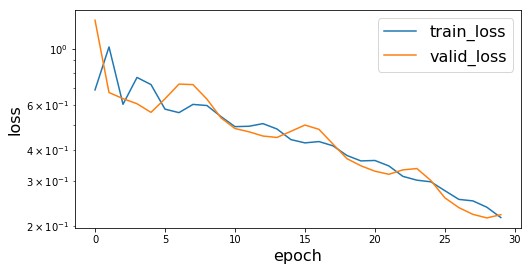

In [27]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.plot(range(len(val_loss)), val_loss, label='valid_loss')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)
plt.show()

In [28]:
y_pred_proba = model.predict(X_test)

y_pred = np.where(y_pred_proba > 0.5 , 1, 0)
print('y_pred_proba', y_pred_proba)
print('y_pred', y_pred)

y_pred_proba [[0.22190037]
 [0.9668453 ]
 [0.19762173]
 [0.9745737 ]
 [0.83750224]
 [0.9671133 ]
 [0.5050224 ]
 [0.7536666 ]
 [0.975723  ]
 [0.8820793 ]
 [0.9353236 ]
 [0.9431972 ]
 [0.9685073 ]
 [0.39341718]
 [0.09749576]
 [0.15006939]
 [0.661341  ]
 [0.0904719 ]
 [0.8423634 ]
 [0.13467616]]
y_pred [[0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]]


In [29]:
evaluation = model.evaluate(X_test, y_test, verbose=2)
evaluation

 - 0s - loss: 0.2985 - acc: 0.8500


[0.29847803711891174, 0.85]

数も少ないので、普通に間違えてる。

# 【問題3】Iris（多値分類）をKerasで学習

In [30]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y = np.array(pd.get_dummies(y))

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [31]:
K.clear_session()
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(4,)))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer=optimizers.Adam(lr=1e-2),
                     loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [32]:
hist = model.fit(X_train, y_train,
                 epochs=40, batch_size=30,
                 validation_data=(X_val, y_val), verbose=2)

Train on 96 samples, validate on 24 samples
Epoch 1/40
 - 0s - loss: 1.2265 - acc: 0.3125 - val_loss: 0.6794 - val_acc: 0.7083
Epoch 2/40
 - 0s - loss: 0.6005 - acc: 0.7708 - val_loss: 0.5174 - val_acc: 0.7083
Epoch 3/40
 - 0s - loss: 0.4469 - acc: 0.7083 - val_loss: 0.3865 - val_acc: 0.9167
Epoch 4/40
 - 0s - loss: 0.3283 - acc: 0.9062 - val_loss: 0.3308 - val_acc: 0.9167
Epoch 5/40
 - 0s - loss: 0.2217 - acc: 0.9896 - val_loss: 0.2753 - val_acc: 0.9167
Epoch 6/40
 - 0s - loss: 0.1638 - acc: 0.9688 - val_loss: 0.2417 - val_acc: 0.9167
Epoch 7/40
 - 0s - loss: 0.1195 - acc: 0.9688 - val_loss: 0.2583 - val_acc: 0.9167
Epoch 8/40
 - 0s - loss: 0.0928 - acc: 0.9792 - val_loss: 0.2088 - val_acc: 0.9167
Epoch 9/40
 - 0s - loss: 0.0846 - acc: 0.9792 - val_loss: 0.2684 - val_acc: 0.9167
Epoch 10/40
 - 0s - loss: 0.0674 - acc: 0.9792 - val_loss: 0.1979 - val_acc: 0.9167
Epoch 11/40
 - 0s - loss: 0.0616 - acc: 0.9792 - val_loss: 0.3169 - val_acc: 0.9167
Epoch 12/40
 - 0s - loss: 0.0880 - acc: 0

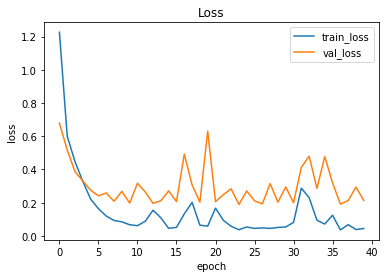

In [33]:
train_loss = hist.history['loss'] #訓練誤差を取得
val_loss = hist.history['val_loss'] #検証誤差を取得

#誤差の履歴をプロット
plt.figure()
plt.title('Loss')
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.plot(range(len(val_loss)), val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

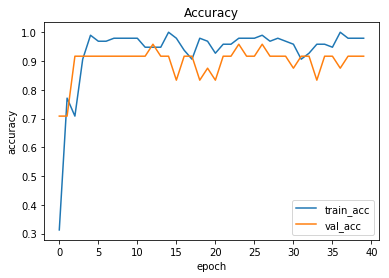

In [34]:
train_acc = hist.history['acc'] #訓練精度を取得
val_acc = hist.history['val_acc'] #検証精度を取得

#精度の履歴をプロット
plt.figure()
plt.title('Accuracy')
plt.plot(range(len(train_acc)), train_acc, label='train_acc')
plt.plot(range(len(val_acc)), val_acc, label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

In [35]:
evaluation = model.evaluate(X_test, y_test, verbose=2)
print('test_loss:%.3f' % evaluation[0])
print('test_accuracy:%.3f' % evaluation[1])

 - 0s - loss: 0.0241 - acc: 1.0000
test_loss:0.024
test_accuracy:1.000


# 【問題4】House PricesをKerasで学習

In [36]:
train = pd.read_csv('train.csv')
train = train[['YearBuilt','GrLivArea','SalePrice']]
train

,YearBuilt,GrLivArea,SalePrice
0,2003,1710,208500
1,1976,1262,181500
2,2001,1786,223500
3,1915,1717,140000
4,2000,2198,250000
5,1993,1362,143000
6,2004,1694,307000
7,1973,2090,200000
8,1931,1774,129900
9,1939,1077,118000


In [37]:
#データをXとyにわける、そしてndarray型へ変更
X = train.drop('SalePrice',axis=1).values
y = train.SalePrice.values

#それぞれ学習用検証用に分割
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
len(X_train),len(X_test),len(y_train),len(y_test) #確認

from sklearn.preprocessing import StandardScaler
#対数変換
y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]
X_train = np.log(X_train)
X_test = np.log(X_test)
y_train = np.log(y_train)
y_test = np.log(y_test)
#標準化
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
#更にもう一回分ける。
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=0)

In [38]:
K.clear_session()
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2,)))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer=optimizers.Adam(lr=1e-2),
                     loss='mse')

Instructions for updating:
Use tf.cast instead.


In [39]:
hist = model.fit(X_train, y_train,
                 epochs=100, batch_size=64,
                 validation_data=(X_val, y_val), verbose=2)

Train on 821 samples, validate on 274 samples
Epoch 1/100
 - 0s - loss: 70.6743 - val_loss: 31.1171
Epoch 2/100
 - 0s - loss: 18.2277 - val_loss: 15.2927
Epoch 3/100
 - 0s - loss: 8.5101 - val_loss: 8.0754
Epoch 4/100
 - 0s - loss: 3.8447 - val_loss: 3.7552
Epoch 5/100
 - 0s - loss: 2.0255 - val_loss: 1.8156
Epoch 6/100
 - 0s - loss: 0.9829 - val_loss: 1.0413
Epoch 7/100
 - 0s - loss: 0.5572 - val_loss: 0.6634
Epoch 8/100
 - 0s - loss: 0.3584 - val_loss: 0.4364
Epoch 9/100
 - 0s - loss: 0.2618 - val_loss: 0.3466
Epoch 10/100
 - 0s - loss: 0.2129 - val_loss: 0.2310
Epoch 11/100
 - 0s - loss: 0.1495 - val_loss: 0.1900
Epoch 12/100
 - 0s - loss: 0.1198 - val_loss: 0.1388
Epoch 13/100
 - 0s - loss: 0.1067 - val_loss: 0.1096
Epoch 14/100
 - 0s - loss: 0.0920 - val_loss: 0.1079
Epoch 15/100
 - 0s - loss: 0.0834 - val_loss: 0.0882
Epoch 16/100
 - 0s - loss: 0.0800 - val_loss: 0.0849
Epoch 17/100
 - 0s - loss: 0.0733 - val_loss: 0.0834
Epoch 18/100
 - 0s - loss: 0.0684 - val_loss: 0.0706
Epoch

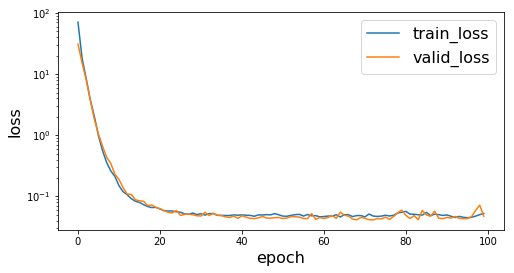

In [40]:
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

plt.figure(figsize=(8, 4))
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.plot(range(len(val_loss)), val_loss, label='valid_loss')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)
plt.show()

In [41]:
#テストデータに対する推定値を計算
prediction = model.predict(X_test)
print('rmse={:.4f}'.format(np.sqrt(mean_squared_error(y_test, prediction))))

rmse=0.2169


In [42]:
print('決定係数={:.4f}'.format(r2_score(y_test, prediction)))

決定係数=0.6836


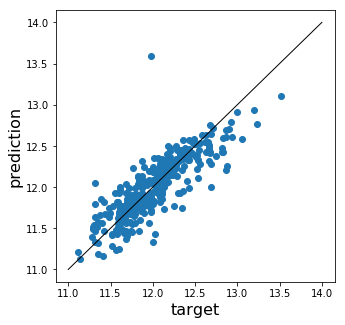

In [43]:
#結果の表示
plt.figure(figsize=(5,5))
plt.scatter(y_test, prediction)
plt.plot((11.,14.), (11,14), color='k', lw=1)
plt.xlabel('target', fontsize=16)
plt.ylabel('prediction', fontsize=16)
plt.show()

# 【問題5】MNISTをKerasで学習

In [44]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train = x_train.reshape(-1, 784)
X_test = x_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [45]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train_one_hot,test_size=0.25,random_state=0)

In [46]:
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(784,)))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer=optimizers.Adam(lr=1e-2),
                     loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [47]:
hist = model.fit(X_train, y_train,
                 epochs=20, batch_size=30,
                 validation_data=(X_val, y_val), verbose=2)

Train on 45000 samples, validate on 15000 samples
Epoch 1/20
 - 2s - loss: 0.3157 - acc: 0.9066 - val_loss: 0.2559 - val_acc: 0.9261
Epoch 2/20
 - 2s - loss: 0.2126 - acc: 0.9392 - val_loss: 0.2414 - val_acc: 0.9335
Epoch 3/20
 - 2s - loss: 0.1880 - acc: 0.9479 - val_loss: 0.2100 - val_acc: 0.9465
Epoch 4/20
 - 2s - loss: 0.1668 - acc: 0.9552 - val_loss: 0.2522 - val_acc: 0.9373
Epoch 5/20
 - 2s - loss: 0.1640 - acc: 0.9569 - val_loss: 0.2019 - val_acc: 0.9506
Epoch 6/20
 - 2s - loss: 0.1552 - acc: 0.9598 - val_loss: 0.2162 - val_acc: 0.9482
Epoch 7/20
 - 2s - loss: 0.1478 - acc: 0.9616 - val_loss: 0.2626 - val_acc: 0.9464
Epoch 8/20
 - 2s - loss: 0.1393 - acc: 0.9646 - val_loss: 0.1831 - val_acc: 0.9529
Epoch 9/20
 - 2s - loss: 0.1320 - acc: 0.9658 - val_loss: 0.2327 - val_acc: 0.9503
Epoch 10/20
 - 2s - loss: 0.1324 - acc: 0.9663 - val_loss: 0.1871 - val_acc: 0.9599
Epoch 11/20
 - 2s - loss: 0.1326 - acc: 0.9671 - val_loss: 0.1735 - val_acc: 0.9589
Epoch 12/20
 - 2s - loss: 0.1186 - 

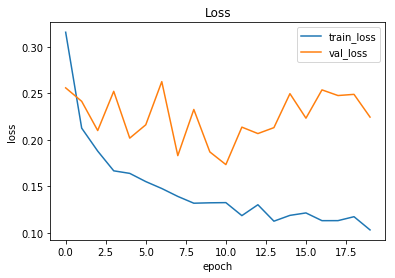

In [48]:
train_loss = hist.history['loss'] #訓練誤差を取得
val_loss = hist.history['val_loss'] #検証誤差を取得

#誤差の履歴をプロット
plt.figure()
plt.title('Loss')
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.plot(range(len(val_loss)), val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

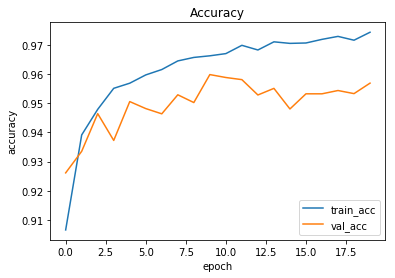

In [49]:
train_acc = hist.history['acc'] #訓練精度を取得
val_acc = hist.history['val_acc'] #検証精度を取得

#精度の履歴をプロット
plt.figure()
plt.title('Accuracy')
plt.plot(range(len(train_acc)), train_acc, label='train_acc')
plt.plot(range(len(val_acc)), val_acc, label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

# 【問題6】（アドバンス課題）PyTorchへの書き換え

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

In [51]:
"""
tf.kerasで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [52]:
#tensorに変換
X_train =  torch.tensor(data=X_train, dtype=torch.float32)
y_train =  torch.tensor(data=y_train, dtype=torch.float32)
X_val =  torch.tensor(data=X_val, dtype=torch.float32)
y_val =  torch.tensor(data=y_val, dtype=torch.float32)
X_test =  torch.tensor(data=X_test, dtype=torch.float32)
y_test =  torch.tensor(data=y_test, dtype=torch.float32)


In [53]:
net = nn.Linear(4,1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.25)

In [54]:
losses = []

for epoc in range(200):
    #１つ前のbackwardの勾配を初期化
    optimizer.zero_grad()
    
    y_pred = net(X_train)
    
    #MSEロスとwによる微分を計算
    #y_pred(n,1)の様なshapeを持っているので(n,)に直す
    loss = loss_fn(y_pred.view_as(y_train), y_train)
    loss.backward()
    
    
    optimizer.step()
    
    losses.append(loss.item())

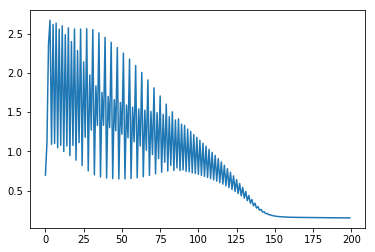

In [55]:
plt.plot(losses)

In [56]:
h = net(X_train)
prob = nn.functional.sigmoid(h)

y_pred = prob > 0.5

(y_train.byte() == y_pred.view_as(y_train)).sum().item()

/Users/takahashiakira/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


63

## 多クラス分類

In [57]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
Y = digits.target

X = torch.tensor(X, dtype=torch.float32)
# クロスエントロピーはint64のtensorとなる。
Y = torch.tensor(Y, dtype=torch.int64)

In [58]:
net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16,10)
)

In [59]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())

losses = []

for epoc in range(500):
    
    #backwardで計算された　勾配を初期化
    optimizer.zero_grad()
    
    y_pred = net(X)
    #lossを計算バックワード
    loss = loss_fn(y_pred , Y)
    loss.backward()
    
    #勾配を更新
    optimizer.step()
    #勾配を貯める
    losses.append(loss.item())

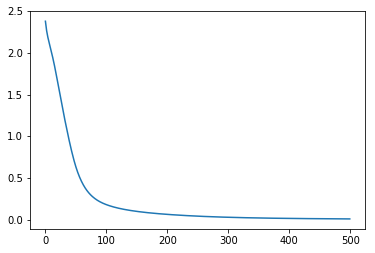

In [60]:
plt.plot(losses)

In [61]:
net.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)>

### DataLoaderを使って、バッチ処理をしてみる。

In [62]:
from torch.utils.data import TensorDataset, DataLoader
# datasetを作成
ds = TensorDataset(X, Y)

# 異なる順番で64個ずつデータを返す。
loader = DataLoader(ds, batch_size=64, shuffle=True)

#モデルを作成
net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

# ソフトマックスクロスエントロピー
loss_fn = nn.CrossEntropyLoss()
#optimizerを初期化
optimizer = optim.Adam(net.parameters())

# 学習
losses = []
for epoch in range(10):
    running_loss = 0.0
    for xx, yy in loader:
        # xx, yyは64個分のみ受け取れる。
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)
    

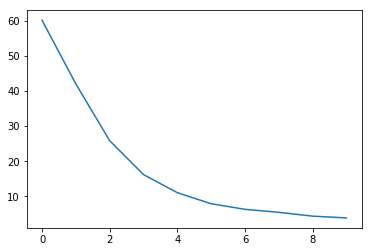

In [63]:
plt.plot(losses)

In [64]:
soft = nn.Softmax()
pred = net(X)
pred = soft(pred)
print('accuracy={:.4f}'.format((torch.argmax(pred,1) == Y).sum().item() / len(Y)))

accuracy=0.9727


/Users/takahashiakira/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
